# ECON 407: Problem Set 4
<b>Professor Peifan Wu</b>

<b>Jack (Quan Cheng) Xie</b> <br>
Student #: 31091325

November 9, 2020

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [2]:
# print bold
textbf = lambda x: '\033[1m'+str(x)+'\033[0m'

## Q1. Tauchen Method

Tauchen method is the simplest method to discretize an AR(1) process. An AR(1) process has the form

$$
x_{t} = \rho x_{t-1} + \epsilon_{t}
$$

where $\epsilon$ follows Normal distribution with standard deviation $\sigma$.

For discrete dynamic programming, it is usually useful to discretize the continuous AR(1) process. We need two ingredients: 1) the points (the states) on the finite state space; and 2) the transition probabilities between each pair of the states. Check the related pdf file.

For the rest of this question, we assume that $\rho = 0.95$ and $\sigma = 0.01$. We choose $m=4$ and $N=15$ for the process (see both of these definitions in the pdf file).

### Q1.1 Coding Tauchen method up
Define a function for Tauchen method that returns the finite state space and the transition matrix. (If you checked some references for this one please mention them)

In [3]:
# cumulative distribution function of standard normal
F = stats.norm(loc=0, scale=1).cdf

# parameters
ρ = 0.95 # autocorrelation coefficient
σ_ϵ = 0.01 # standard deviation of noise
m = 4 # max value multiple
N = 15 # number of states

def tauchen():
    '''
    Returns state space and transition probability matrix
    of discretized AR(1) process with Tauchen method
    
    Global parameters defined above
    '''
    # maximum value
    y_N = m * np.sqrt(σ_ϵ**2 / (1 - ρ**2))

    # y_1 = -y_N, and y's are evenly spaced for N states
    y_grid = np.linspace(-y_N, y_N, N)

    # average distance between successive points in grid space
    d = 2 * y_N / (N-1)

    # initialize transition probability matrix
    π = np.zeros((N, N))
    
    # prob from state j
    for j in range(N):
        
        # to state k
        for k in range(N):
            
            # cumulative probabilities to bounds of discrete state intervals
            rbound = F((y_grid[k] + (d/2) - ρ*y_grid[j]) / σ_ϵ)
            lbound = F((y_grid[k] - (d/2) - ρ*y_grid[j]) / σ_ϵ)
            
            # probabilities broundary case
            if k == 0:
                # capture all probability to left of bound
                π[j, k] = rbound
            elif k == (N - 1):  
                # capture all probability to right of bound
                π[j, k] = 1 - lbound
            else:
                # probability of interval between left and right
                π[j, k] = rbound - lbound
    
    # return finite state space and transition matrix
    return y_grid, π

### Q1.2 Simulation and check the statistics
Now you have a discretized Markov Chain for this continuous AR(1) process. Randomly simulate this process for 1000 periods by setting the state of the first period as 8 (since we have 15 states and they are symmetric, the starting period would be 0). For the sample chain you got, compute the 1) autocorrelation of the realizations; 2) the unconditional variance of the process. What do you find?

In [4]:
# simulation

# generate state space and transition matrix
x_grid, P = tauchen()

# simulate 1000 periods
T = 1000

# initial state
s0 = 7 # state 8, index 7

# initialize states history
S = np.zeros(T, dtype='i')

# initialize values history
x = np.zeros(T)

# update initial state
S[0] = s0
x[0] = x_grid[s0]

# draw random numbers
prob_draw = np.random.rand(T)

# simulate
for t in range(T-1):
    
    # current distribution
    curr_dist = P[int(S[t])]
    
    # cumulative probability
    cum_prob = curr_dist.cumsum()
    
    # next state
    s = cum_prob.searchsorted(prob_draw[t])
    
    # update next state
    S[t+1] = s
    
    # update next value
    x[t+1] = x_grid[s]


In [5]:
# compute autocorrelation
def auto_corr(x, τ=1):
    '''
    Returns autocorrelation of series x with τ periods lag
    '''
    x = np.array(x)
    cov = np.cov(x[:-τ], x[τ:], bias=True)[0, 1]
    return cov / x.var()

# simulation auto-correlation
sim_ρ = auto_corr(x)

# simulation variance
sim_va = x.var()

# compute unconditional variance from parameters
va = (σ_ϵ**2) / (1-ρ**2)

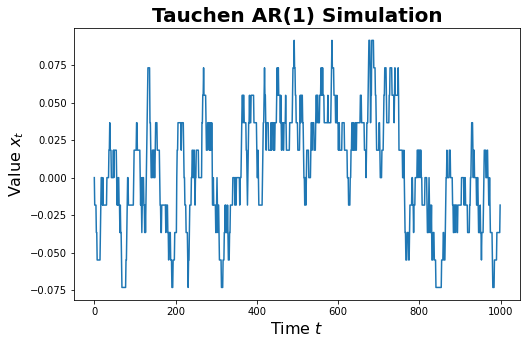


Auto correlation
Simulated: 0.9507
ρ: 0.95

Unconditional variance
Simulated: 0.00137
(σ_ϵ^2) / (1-ρ^2): 0.00103


In [6]:
# show results

plt.figure(figsize=(8, 5))

plt.plot(x)

plt.xlabel('Time $t$', fontsize=16)
plt.ylabel('Value $x_t$', fontsize=16)
plt.title('Tauchen AR(1) Simulation', fontsize=20, fontweight='bold')

plt.show()

print('\nAuto correlation')
print('Simulated:', textbf(round(sim_ρ, 5)))
print('ρ:', textbf(round(ρ, 5)))

print('\nUnconditional variance')
print('Simulated:', textbf(round(sim_va, 5)))
print('(σ_ϵ^2) / (1-ρ^2):', textbf(round(va, 5)))

The autocorrelation of the simulation is similar to our $\rho$ parameter.

The unconditional variance of the simulation is similar to the unconditional variance calculated from our parameter, $\frac{\sigma_\epsilon^2}{1 - \rho^2}$.

---

## Q2. A Modified RBC model

We think about a model with the so-called "investment cost shock" instead of the usual TFP shock that we have. This question solves a drastically simplified version of Justiniano, Primiceri, and Tambalotti (2011).

Consider a representative agent that lives forever. Time is discrete. The agent wishes to maximize the expectation of discounted sum of utility,

$$
\max_{\left\{ c_{t}\right\} }\mathbb{E}\left[\sum_{t=0}^{\infty}\beta^{t}u\left(c_{t}\right)\right]
$$
 
This agent owns capital $k_t$ at the beginning of time period $t$, and produce some final output following a production function $y=f\left(k\right)$. She can choose to consume or to invest the final output, therefore, facing a budget constraint

$$
\begin{align*}
c_{t}+i_{t} & \leqslant y_{t}\\
y_{t} & =f\left(k_{t}\right)
\end{align*}
$$

There's an investment cost shock, denoted as $z$. $z$ is a discrete, exogenous Markov process. And the capital accumulates following

$$
k_{t+1}=\left(1-\delta\right)k_{t}+\exp\left(z_{t}\right)i_{t}
$$

The difference between this model and the classical RBC model that we covered in class is that the shock is no longer scaling the production function, but rather on the investment that agents choose.

### Q2.1 The Bellman equation

Write down the Bellman equation of this problem. As you Markovize this problem, you can denote the variables at time $t$ as $c,i,k,y,z$, and the variables at time $t+1$ as $c',i', k', y', z'$.

---
#### Preliminaries

First, let's rearrange some terms:

$$
\begin{align}
    c_t + i_t &\le y_t = f(k_t) \\
    i_t &= f(k_t) - c_t \quad*\\
    \\
    k_{t+1} &= (1 - \delta) k + \exp(z_t) i_t \\
    &= (1 - \delta) k + \exp(z_t)(f(k_t) - c_t) \\
    \\
    c_t &= f(k_t) - \frac{k_{t+1} - (1 - \delta) k}{\exp(z_t)}
\end{align}
$$


<br><br>
$*$ Applying equality here assumes no free disposal.

#### Bellman Equation

Let $\mathbb{S}$ denote the state space of exogenous investment shocks $z$. Our Bellman equation is then:

$$
\begin{align}
    V(z, c) &= \max_{c} \left\{ u(c) + \beta \, \mathbb{E} \left[ V(z', c') \right] \right\} \\
    &=
    \max_{k'}\left\{
    u \left( % utility function
        f(k_t) - \frac{k_{t+1} - (1 - \delta) k}{\exp(z_t)} % consumption
    \right)
    + \beta \, \sum_{z' \in \mathbb{S}} q(z') \left[ V(z', c') \right] % discounted expected value next period
    \right\}
\end{align}
$$

---

### Q2.2 Solve the problem

We assume some functional forms and parameter values. $u\left(c\right)=\log\left(c\right)$, $f\left(k\right)=k^{\alpha}$. For the parameters,

| Parameter | Value |
|-----------|-------|
| $\alpha$  | 0.33  |
| $\beta$   | 0.96  |
| $\delta$  | 0.1   |

And $z$ follows a 3-state Markov chain,

$$
\begin{align*}
z & =\left[-0.02,0,0.02\right]\\
P & =\left[\begin{array}{ccc}
0.8 & 0.15 & 0.05\\
0.1 & 0.8 & 0.1\\
0.05 & 0.15 & 0.8
\end{array}\right]
\end{align*}
$$

Solve the value function (hint: the state variables are the same as what we did in the class -- both $z$ and $k$. You can probably use the same grid of capital that we did in class). Describe the economic intuition behind it.

In [7]:
from numba import njit
import pandas as pd

In [8]:
# parameters


# transition probabilities of z
P = np.array([
    [0.8, 0.15, 0.05],
    [0.1, 0.8, 0.1],
    [0.05, 0.15, 0.8]]
)

# capital state space
n_k = 100
k_min = 0.01
k_max = 6.0
k_grid = np.linspace(k_min, k_max, n_k)


# utility and production functions

@njit
def u(c):
    '''
    Utility function.
    
    Arguments
        c : consumption vector
    '''
    
    # utility is log of consumption
    res = np.log(c)
    
    # set large negative utility for zero consumption
    res[np.isnan(res)] = -1e10
    
    return res

@njit
def f(k, α, z=0):
    '''
    Production function.
    
    Arguments
        k : capital
        α : span of control
        z : production shock - default 0 (no shock)
    '''
    return np.exp(z)*k**α

In [9]:
@njit
def RBC(
        α = 0.33, # production span of control
        β = 0.96, # discount factor
        δ = 0.1, # depreciation rate of capital
        z_grid = np.array([-0.02, 0, 0.02]) # investment shock state space
        ):
    
    # number of investment shock states
    n_z = len(z_grid)
    
    V = np.zeros((n_z, n_k)) # initialize value function
    policy = np.zeros((n_z, n_k)) # initalize policy function
    consumption = np.zeros((n_z, n_k)) # initalize consumption
    investment = np.zeros((n_z, n_k)) # initalize consumption
    
    i = 0 # iteration counter

    while True: # iterate until convergence

        V_prime = V.copy()
        
        for j in range(n_z): # index investment shock states z

            for k in range(n_k): # index capital states k

                # production given capital
                prod = f(k_grid[k], α)
                
                # consumption for all k'
                c_grid = prod - ((k_grid - (1 - δ) * k_grid[k]) / np.exp(z_grid[j]))

                # values for all k'
                tmp = u(c_grid) + β * np.dot(P[j], V_prime)

                # max value on k' given capital and realization of investment shock
                V[j, k] = tmp.max()

                # optimal value index
                argmax = tmp.argmax()
                
                # optimal amount of capital to leave for next period (after consumption)
                policy[j, k] = k_grid[argmax]
                
                # consumption and investment
                consumption[j, k] = c_grid[argmax]
                investment[j, k] =  prod - consumption[j, k]
        
        # update iteration counter
        i += 1
        
        # check convergence
        if np.abs(V - V_prime).sum() < 1e-4:

            return V, policy, consumption, investment, z_grid


In [10]:
def plot_RBC(V, policy, consumption, investment, z_grid):

    # formatting
    plot_fmt = dict(alpha=0.5, lw=3)
    title_fmt = dict(fontsize=20)
    label_fmt = dict(fontsize=16, fontweight='bold')

    # set up plot
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # plot value function        
    ax[0, 0].plot(k_grid, V.T, **plot_fmt)
    ax[0, 0].set_ylabel('Value $V(z, k)$', **label_fmt)

    # plot policy function k'
    ax[0, 1].plot(k_grid, policy.T, **plot_fmt)

    # plot k' = k (90-degree) line
    ax[0, 1].plot(k_grid, k_grid,
                  ls='--', lw=3, c='gray', alpha=0.7,
                  label='$k = k\'$')
    ax[0, 1].set_ylabel('Policy $k\'$', **label_fmt)

    # plot consumption
    ax[1, 0].plot(k_grid, consumption.T, **plot_fmt)
    ax[1, 0].set_ylabel('Consumption $c$', **label_fmt)

    # plot investment
    ax[1, 1].plot(k_grid, investment.T, **plot_fmt)
    ax[1, 1].set_ylabel('Investment $i$', **label_fmt)

    # legend labels for realization of z
    legend_labels = [f'z={z}' for z in z_grid]

    for x in ax:
        for y in x:
            y.legend(legend_labels)
    ax[0, 1].legend(legend_labels + ['$k = k\'$'])

    # x label
    fig.text(0.5, .05, 'Capital $k$',
             verticalalignment='center',
             horizontalalignment='center',
             **label_fmt
            )
    # title
    fig.suptitle('RBC Model Solution',
             fontsize=25,
             fontweight='bold'
            )

    plt.show()

    # reorganize results in pandas
    v_res, p_res = {}, {}
    for v, p, z in zip(V, policy, z_grid):
        v_res[f'Value V(z = {z})'] = v
        p_res[f'Policy k\'(z = {z})'] = p

    v_res.update(p_res)

    df = pd.DataFrame(v_res, index=k_grid)
    df.index.name = 'k (capital)'


    print('\n')
    print(textbf('Results Table'))
    print(textbf('-'*50))

    display(df[::9]) # show every ninth row


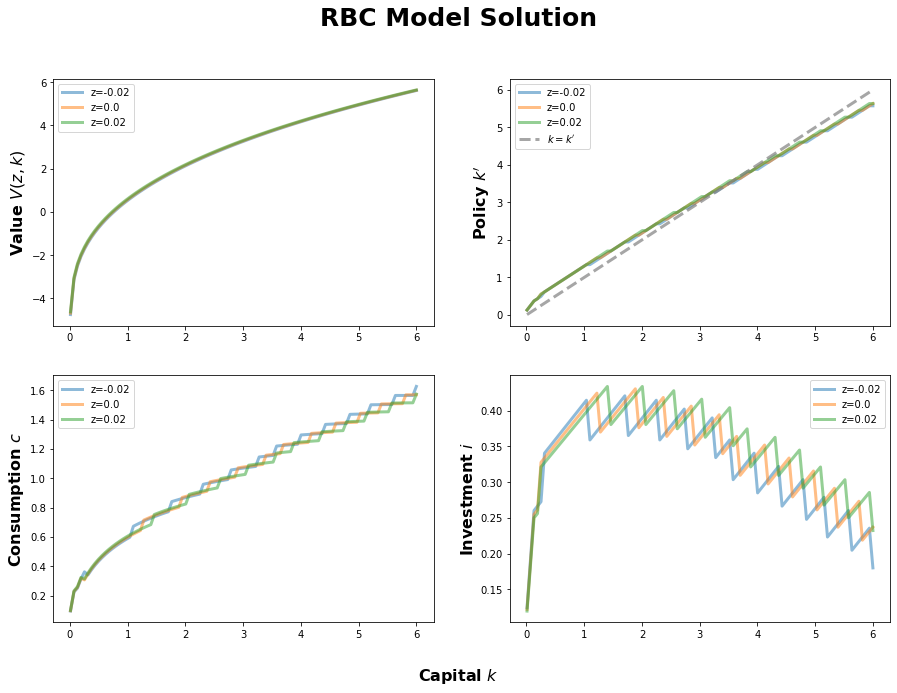



Results Table
--------------------------------------------------


,Value V(z = -0.02),Value V(z = 0.0),Value V(z = 0.02),Policy k'(z = -0.02),Policy k'(z = 0.0),Policy k'(z = 0.02)
k (capital),,,,,,
0.010000,-4.752750,-4.687051,-4.623246,0.131010,0.131010,0.131010
0.554545,-0.561120,-0.516267,-0.472054,0.857071,0.857071,0.857071
1.099091,0.719265,0.757091,0.795150,1.341111,1.401616,1.401616
1.643636,1.628753,1.661136,1.694189,1.885657,1.885657,1.885657
2.188182,2.358553,2.387163,2.416190,2.369697,2.369697,2.369697
2.732727,2.978655,3.004183,3.030320,2.853737,2.853737,2.853737
3.277273,3.523963,3.546211,3.569905,3.277273,3.337778,3.337778
3.821818,4.013326,4.033080,4.053940,3.761313,3.761313,3.821818
4.366364,4.458816,4.476963,4.495558,4.245354,4.245354,4.245354


Wall time: 2.52 s


In [11]:
%%time

# show results
plot_RBC(*RBC())

The agent chooses how much to consume in each period by choosing $k'$, how much capital to leave for next period, given his capital $k$ and the exogenous investment shock $z$ in period $t$. The more capital an agent has in any period, the more he will consume, and the less he will leave for the next period in proportion. We see this in the general "slope" of the policy function is less than the 90-degree line (indicates the policy of saving as much capital for next period as the agent has in the current period).

Since the difference between investment shocks are very small $z = [-0.02, 0, 0.02]$, the agent's policy function are much more similar between the different realization of states than compared to the states $z = [-0.1, 0, 0.1]$ we saw in class.

Even given the same $z$ state space, we see that the value and policy function are much more similar across the realization of the investment shocks than in the production shock model we used in class. The agent's policy is less affected by an investment shock used in this model than by a production shock in the previous RBC model.

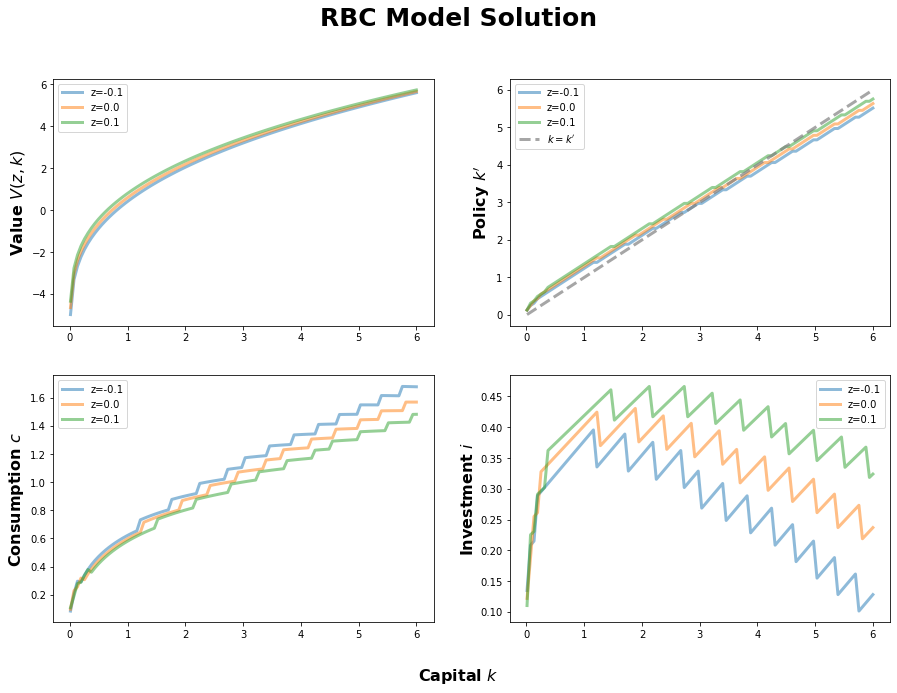



Results Table
--------------------------------------------------


,Value V(z = -0.1),Value V(z = 0.0),Value V(z = 0.1),Policy k'(z = -0.1),Policy k'(z = 0.0),Policy k'(z = 0.1)
k (capital),,,,,,
0.010000,-4.985171,-4.650756,-4.346985,0.131010,0.131010,0.131010
0.554545,-0.692758,-0.477881,-0.249545,0.796566,0.857071,0.917576
1.099091,0.615763,0.795721,0.991059,1.341111,1.401616,1.462121
1.643636,1.544875,1.699917,1.870789,1.825152,1.885657,1.946162
2.188182,2.290093,2.426093,2.577704,2.309192,2.369697,2.430202
2.732727,2.923633,3.043201,3.179377,2.732727,2.853737,2.974747
3.277273,3.479487,3.584999,3.708380,3.216768,3.337778,3.398283
3.821818,3.978015,4.071860,4.183496,3.700808,3.761313,3.882323
4.366364,4.432517,4.515957,4.617147,4.124343,4.245354,4.366364


Wall time: 1.55 s


In [12]:
%%time

# using same z-states as production shock model
z_grid = np.array([-0.1, 0, 0.1])

plot_RBC(*RBC(z_grid=z_grid))